In [1]:
import torch
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt
import librosa
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import copy

In [2]:
# Load the Whisper model and processor
model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-large", output_attentions=True, output_hidden_states=True
)
processor = WhisperProcessor.from_pretrained("openai/whisper-large")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.85k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Path to the audio file in Google Drive
#audio_file_path = '/content/drive/MyDrive/path_to_your_audio_file.wav'

Mounted at /content/drive


In [6]:
# Load the audio file using librosa
audio_without_noises_path = "/content/drive/MyDrive/musicml/gct634_final_project/audio_sample.wav"
audio_with_noises_path = "/content/drive/MyDrive/musicml/gct634_final_project/ariana_cafe.wav"

audio_without_noise, sr = librosa.load(audio_without_noises_path, sr=16000)  # Ensure the sampling rate is 16000
audio_without_noise_input = processor(audio_without_noise, sampling_rate=sr, return_tensors="pt").input_features

audio_with_noise, sr = librosa.load(audio_with_noises_path, sr=16000)  # Ensure the sampling rate is 16000
audio_with_noise_input = processor(audio_with_noise, sampling_rate=sr, return_tensors="pt").input_features

# Run the model to get the outputs


In [7]:

# Dictionaries to store activations for both runs
activations_without_noise = {}
activations_with_noise = {}

def get_activation(name, store_dict):
    def hook(model, input, output):
        store_dict[name] = output.detach()
    return hook

model.eval()

# The decoder input typically starts with the BOS token for Whisper
bos_token_id = processor.tokenizer.bos_token_id
decoder_input_ids = torch.tensor([[bos_token_id]], device=model.device)

# Function to run model and capture activations
def run_model_and_capture_activations(input_features, activations_store):
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv1d):
            hooks.append(layer.register_forward_hook(get_activation(name, activations_store)))

    with torch.no_grad():
        output = model(input_features=input_features, decoder_input_ids=decoder_input_ids)

    for hook in hooks:
        hook.remove()
    return output

# Run the model without noise and capture activations
output_without_noise = run_model_and_capture_activations(audio_without_noise_input, activations_without_noise)

# Run the model with noise and capture activations
output_with_noise = run_model_and_capture_activations(audio_with_noise_input, activations_with_noise)

# Print activations without noise
print("Activations without noise:")
for name, activation in activations_without_noise.items():
    print(f"Layer: {name} | Activation shape: {activation.shape}")

# Print activations with noise
print("Activations with noise:")
for name, activation in activations_with_noise.items():
    print(f"Layer: {name} | Activation shape: {activation.shape}")

WhisperModel is using WhisperSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Activations without noise:
Layer: model.encoder.conv1 | Activation shape: torch.Size([1, 1280, 3000])
Layer: model.encoder.conv2 | Activation shape: torch.Size([1, 1280, 1500])
Activations with noise:
Layer: model.encoder.conv1 | Activation shape: torch.Size([1, 1280, 3000])
Layer: model.encoder.conv2 | Activation shape: torch.Size([1, 1280, 1500])


In [8]:
# 1D convolution -> 1280 x 3000
print(activations_without_noise['model.encoder.conv1'])
# 1D convolution -> 1280 x 1500
print(activations_with_noise['model.encoder.conv1'])

tensor([[[ 0.1164,  0.0200,  0.0200,  ...,  0.1745,  0.1348, -0.0832],
         [-0.0638,  0.0524,  0.0524,  ...,  0.1386,  0.1224,  0.1573],
         [ 0.0099, -0.0456, -0.0456,  ...,  0.2354,  0.2484,  0.1828],
         ...,
         [ 0.0962,  0.0842,  0.0842,  ...,  0.0010,  0.0615, -0.0772],
         [ 0.0411,  0.0609,  0.0609,  ...,  0.2566,  0.2490,  0.2013],
         [ 0.0522,  0.1108,  0.1108,  ...,  0.1198,  0.1935,  0.0077]]])
tensor([[[ 0.1288,  0.0169,  0.0169,  ...,  0.0898,  0.0776,  0.0655],
         [-0.0880,  0.0470,  0.0470,  ...,  0.2543,  0.1481,  0.1096],
         [-0.0051, -0.0696, -0.0696,  ...,  0.1461,  0.2215,  0.1901],
         ...,
         [ 0.0911,  0.0772,  0.0772,  ...,  0.1792,  0.2211,  0.0147],
         [ 0.0291,  0.0521,  0.0521,  ...,  0.2365,  0.1906,  0.1783],
         [ 0.0426,  0.1107,  0.1107,  ...,  0.2127,  0.1719, -0.0934]]])


In [9]:
# 1D convolution -> 1280 x 3000
print(activations_without_noise['model.encoder.conv2'])
# 1D convolution -> 1280 x 1500
print(activations_with_noise['model.encoder.conv2'])

tensor([[[-1.4684, -2.0565, -2.0565,  ..., -2.9072, -2.8382, -2.8039],
         [-0.7048, -1.2516, -1.2516,  ..., -3.1055, -3.0941, -2.9223],
         [-1.2490, -1.6036, -1.6036,  ..., -3.2901, -3.2809, -3.3079],
         ...,
         [-0.0627,  0.1347,  0.1347,  ...,  0.3092,  0.3035, -0.3334],
         [ 0.7090,  0.4859,  0.4859,  ..., -1.7173, -1.5776, -1.0598],
         [-0.0092,  0.0691,  0.0691,  ...,  0.0869,  0.1102,  0.2130]]])
tensor([[[-1.4895, -2.0262, -2.1466,  ..., -2.7041, -2.6628, -2.6163],
         [-0.6447, -1.1603, -1.3774,  ..., -2.4089, -2.3604, -2.3423],
         [-1.2554, -1.5408, -1.5618,  ..., -2.7187, -2.7540, -2.8722],
         ...,
         [-0.1328,  0.0820, -0.2089,  ...,  0.3500,  0.5648, -0.0449],
         [ 0.7885,  0.5525,  0.5416,  ..., -0.0932, -0.3825, -0.2433],
         [-0.0339,  0.0410,  0.1230,  ..., -0.1821,  0.1255,  0.0171]]])


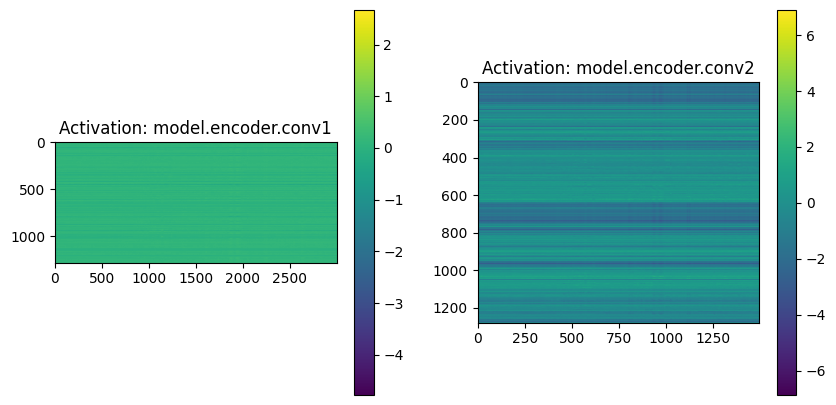

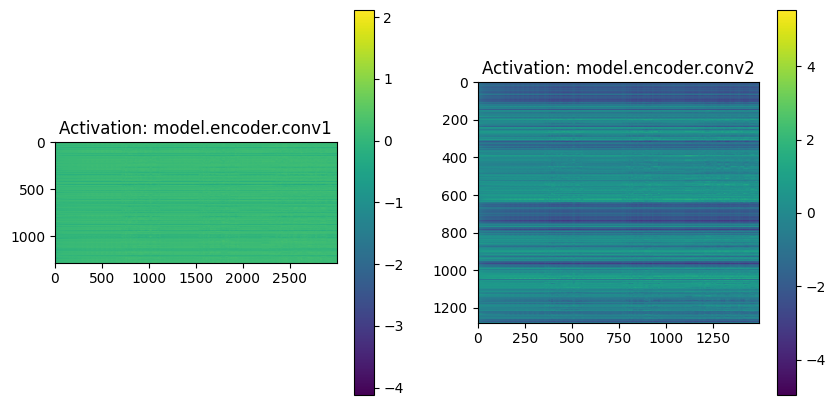

tensor(0.0281)
tensor(0.2353)
Convolutional Entropy (With Noise): 15.139284133911133
Convolutional Entropy (Without Noise): 15.134364128112793
Convolutional Entropy 2 (With Noise): 13.983131408691406
Convolutional Entropy 2 (Without Noise): 13.847762107849121


In [36]:
# Function to visualize activations side by side
def visualize_activations(activations):
    num_activations = len(activations)
    plt.figure(figsize=(5 * num_activations, 5))

    for idx, (name, activation) in enumerate(activations.items()):
        # Assume activation is 4D tensor: (batch_size, channels, height, width)
        channels, height, width = activation.shape
        # Plot the first channel of the first sample
        activation_img = activation[0, :, :].cpu().numpy()

        plt.subplot(1, num_activations, idx + 1)
        plt.imshow(activation_img, cmap='viridis')
        plt.title(f'Activation: {name}')
        plt.colorbar()

    plt.show()

# Function to calculate mean squared difference
def mean_squared_difference(matrix1, matrix2):
    # Compute the difference between the two matrices
    difference = matrix1 - matrix2

    # Square each element of the difference matrix
    squared_difference = difference ** 2

    # Compute the mean of all the squared differences
    mean_squared_diff = torch.mean(squared_difference)

    return mean_squared_diff


# Function to calculate entropy
def calculate_entropy(tensor):
    # Flatten the tensor and apply softmax along the last dimension
    softmax_tensor = F.softmax(tensor.flatten(start_dim=1), dim=1)
    # Reshape back to the original shape if needed
    softmax_tensor = softmax_tensor.reshape(tensor.shape)
    # Calculate entropy
    entropy = -torch.sum(softmax_tensor * torch.log(softmax_tensor + 1e-9), dim=[1, 2])  # Sum over the spatial dimensions
    average_entropy = torch.mean(entropy)
    return average_entropy.item()

# Visualize the captured activations
visualize_activations(activations_with_noise)
visualize_activations(activations_without_noise)
#print(activations['model.encoder.conv1'] -  activations2['model.encoder.conv1'])
print(mean_squared_difference(activations_with_noise['model.encoder.conv1'], activations_without_noise['model.encoder.conv1']))
print(mean_squared_difference(activations_with_noise['model.encoder.conv2'], activations_without_noise['model.encoder.conv2']))

conv_entropy_with_noise = calculate_entropy(activations_with_noise['model.encoder.conv1'])
print(f"Convolutional Entropy (With Noise): {conv_entropy_with_noise}")

# Calculate convolutional entropy for activations without noise
conv_entropy_without_noise = calculate_entropy( activations_without_noise['model.encoder.conv1'])
print(f"Convolutional Entropy (Without Noise): {conv_entropy_without_noise}")


conv_entropy_with_noise = calculate_entropy(activations_with_noise['model.encoder.conv2'])
print(f"Convolutional Entropy 2 (With Noise): {conv_entropy_with_noise}")

# Calculate convolutional entropy for activations without noise
conv_entropy_without_noise = calculate_entropy( activations_without_noise['model.encoder.conv2'])
print(f"Convolutional Entropy 2 (Without Noise): {conv_entropy_without_noise}")

In [11]:
# Extract attention weights and hidden states
# Key, Query
with_noise_encoder_attentions = output_with_noise.encoder_attentions
print(with_noise_encoder_attentions[0].size())
without_noise_encoder_attentions = output_without_noise.encoder_attentions

# Tuple = 32 layers, 20 attention heads, 1500 x 1500 key and queries
with_noise_decoder_attentions = output_with_noise.decoder_attentions
without_noise_decoder_attentions = output_without_noise.encoder_attentions
#cross_attentions = outputs.cross_attentions
#encoder_hidden_states = outputs.encoder_hidden_states

torch.Size([1, 20, 1500, 1500])


In [33]:
# Function to calculate mean squared difference
def mean_squared_difference(tensor1, tensor2):
    return torch.mean((tensor1 - tensor2) ** 2)

# Function to calculate attention sparsity
def attention_sparsity(attention_weights, threshold=9e-7):
    num_elements = attention_weights.numel()
    sparse_elements = (attention_weights <= threshold).sum().item()
    sparsity = sparse_elements / num_elements
    return sparsity

# Initial layer analysis
print(mean_squared_difference(with_noise_encoder_attentions[0][0], without_noise_encoder_attentions[0][0]).item())

# With Noise
attention_maps = F.softmax(with_noise_encoder_attentions[0][0].flatten(start_dim=1), dim=1)  # Flatten and apply softmax along the correct dimension
attention_maps = attention_maps.reshape(-1, 1500, 1500)  # Reshape back to original shape if needed

# Calculate entropy for each head
entropies = -torch.sum(attention_maps * torch.log(attention_maps + 1e-9), dim=[1, 2])  # Sum over the spatial dimensions
average_entropy = torch.mean(entropies)
print(f"Average Attention Entropy At Layer 0 (With Noise): {average_entropy.item()}")

# Calculate mean attention sparsity
mean_sparsity_with_noise = attention_sparsity(attention_maps)
print(f"Mean Attention Sparsity At Layer 0 (With Noise): {mean_sparsity_with_noise}")

# Without Noise
attention_maps = F.softmax(without_noise_encoder_attentions[0][0].flatten(start_dim=1), dim=1)  # Flatten and apply softmax along the correct dimension
attention_maps = attention_maps.reshape(-1, 1500, 1500)  # Reshape back to original shape if needed

# Calculate entropy for each head
entropies = -torch.sum(attention_maps * torch.log(attention_maps + 1e-9), dim=[1, 2])  # Sum over the spatial dimensions
average_entropy = torch.mean(entropies)
print(f"Average Attention Entropy At Layer 0 (Without Noise): {average_entropy.item()}")

# Calculate mean attention sparsity
mean_sparsity_without_noise = attention_sparsity(attention_maps)
print(f"Mean Attention Sparsity At Layer 0 (Without Noise): {mean_sparsity_without_noise}")

# Final layer analysis
print(mean_squared_difference(with_noise_encoder_attentions[31][0], without_noise_encoder_attentions[31][0]).item())

# With Noise
attention_maps = F.softmax(with_noise_encoder_attentions[31][0].flatten(start_dim=1), dim=1)  # Flatten and apply softmax along the correct dimension
attention_maps = attention_maps.reshape(-1, 1500, 1500)  # Reshape back to original shape if needed

# Calculate entropy for each head
entropies = -torch.sum(attention_maps * torch.log(attention_maps + 1e-9), dim=[1, 2])  # Sum over the spatial dimensions
average_entropy = torch.mean(entropies)
print(f"Average Attention Entropy At Final Layer (With Noise): {average_entropy.item()}")

# Calculate mean attention sparsity
mean_sparsity_with_noise = attention_sparsity(attention_maps)
print(f"Mean Attention Sparsity At Final Layer (With Noise): {mean_sparsity_with_noise}")

# Without Noise
attention_maps = F.softmax(without_noise_encoder_attentions[31][0].flatten(start_dim=1), dim=1)  # Flatten and apply softmax along the correct dimension
attention_maps = attention_maps.reshape(-1, 1500, 1500)  # Reshape back to original shape if needed

# Calculate entropy for each head
entropies = -torch.sum(attention_maps * torch.log(attention_maps + 1e-9), dim=[1, 2])  # Sum over the spatial dimensions
average_entropy = torch.mean(entropies)
print(f"Average Attention Entropy At Final Layer (Without Noise): {average_entropy.item()}")

# Calculate mean attention sparsity
mean_sparsity_without_noise = attention_sparsity(attention_maps)
print(f"Mean Attention Sparsity At Final Layer (Without Noise): {mean_sparsity_without_noise}")

4.521280061453581e-06
Average Attention Entropy At Layer 0 (With Noise): 14.627758979797363
Mean Attention Sparsity At Layer 0 (With Noise): 0.9999904222222222
Average Attention Entropy At Layer 0 (Without Noise): 14.626986503601074
Mean Attention Sparsity At Layer 0 (Without Noise): 0.9999920222222223
3.261053643655032e-05
Average Attention Entropy At Final Layer (With Noise): 14.616012573242188
Mean Attention Sparsity At Final Layer (With Noise): 0.9999994444444444
Average Attention Entropy At Final Layer (Without Noise): 14.62572193145752
Mean Attention Sparsity At Final Layer (Without Noise): 0.9999992888888889


In [23]:
# Function to plot a 3 x n grid of attention maps and activations
def plot_attention_maps(encoder_attentions):
    n_layers = len(encoder_attentions)
    fig, axes = plt.subplots(n_layers, 3, figsize=(15, n_layers * 5))

    for idx in range(n_layers):
        # Encoder Attention Head 1
        if encoder_attentions:
            ax = axes[idx, 0]
            attention_map = encoder_attentions[idx][0][0].cpu().detach().numpy()
            ax.imshow(attention_map, cmap='viridis', aspect='auto')
            ax.set_title(f'Encoder Attention Head 1 (Layer {idx+1})')
            ax.set_xlabel('Keys')
            ax.set_ylabel('Queries')
            fig.colorbar(ax.imshow(attention_map, cmap='viridis', aspect='auto'), ax=ax)

        # Encoder Attention Head 2
        if encoder_attentions:
            ax = axes[idx, 1]
            attention_map = encoder_attentions[idx][0][1].cpu().detach().numpy()
            ax.imshow(attention_map, cmap='viridis', aspect='auto')
            ax.set_title(f'Encoder Attention Head 2 (Layer {idx+1})')
            ax.set_xlabel('Keys')
            ax.set_ylabel('Queries')
            fig.colorbar(ax.imshow(attention_map, cmap='viridis', aspect='auto'), ax=ax)

        # Encoder Attention Head 3
        if encoder_attentions:
            ax = axes[idx, 2]
            attention_map = encoder_attentions[idx][0][2].cpu().detach().numpy()
            ax.imshow(attention_map, cmap='viridis', aspect='auto')
            ax.set_title(f'Encoder Attention Head 3 (Layer {idx+1})')
            ax.set_xlabel('Keys')
            ax.set_ylabel('Queries')
            fig.colorbar(ax.imshow(attention_map, cmap='viridis', aspect='auto'), ax=ax)

    plt.tight_layout()
    plt.show()

#plot_attention_maps(encoder_attentions)
